In [13]:
# author: Carlos F. Dietrich (carlos.dietrich@tum.de)
# reviewer: Francisco J. Guerrero-Gonzalez
# version: 1.0.0

Copyright 2023, Professorship of Lunar and Planetary Exploration, Technical University of Munich.

Permission is hereby granted, free of charge, to any person obtaining a copy of this model and associated documentation files, without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the models, and to permit persons to whom the model is furnished to do so, subject to the following conditions:

1. The above copyright notice and this permission notice shall be included in all copies or substantial portions of the model, as well as reference to the author(s) listed above. Scientific publications which use this model shall cite the [ISRULib documentation site](https://wiki.tum.de/display/lpe/ISRULib) attributing credit to the named authors in the documentation.

2. The model is provided without warranty of any kind, express or implied, including but not limited to the warranties of merchantability, fitness for a particular purpose, and non-infringement. In no event shall the authors or copyright holders be liable for any claim, damages, or other liability, whether in an action of contract, tort, or otherwise, arising from, out of, or in connection with the model or the use or other dealings in the model.

# Hopper

In [14]:
# Python Libraries
import numpy as np
import matplotlib.pyplot as plt

from IPython import display

**Model Description**

A hopper is a container that can receive, store, and discharge granular feedstock. In most cases, the material is discharged at the bottom due to gravity. The material flow could be enhanced by, e.g., vibration of the hopper. Usually an auger conveyor is placed at the bottom of the hopper as final feeding system (see picture below).

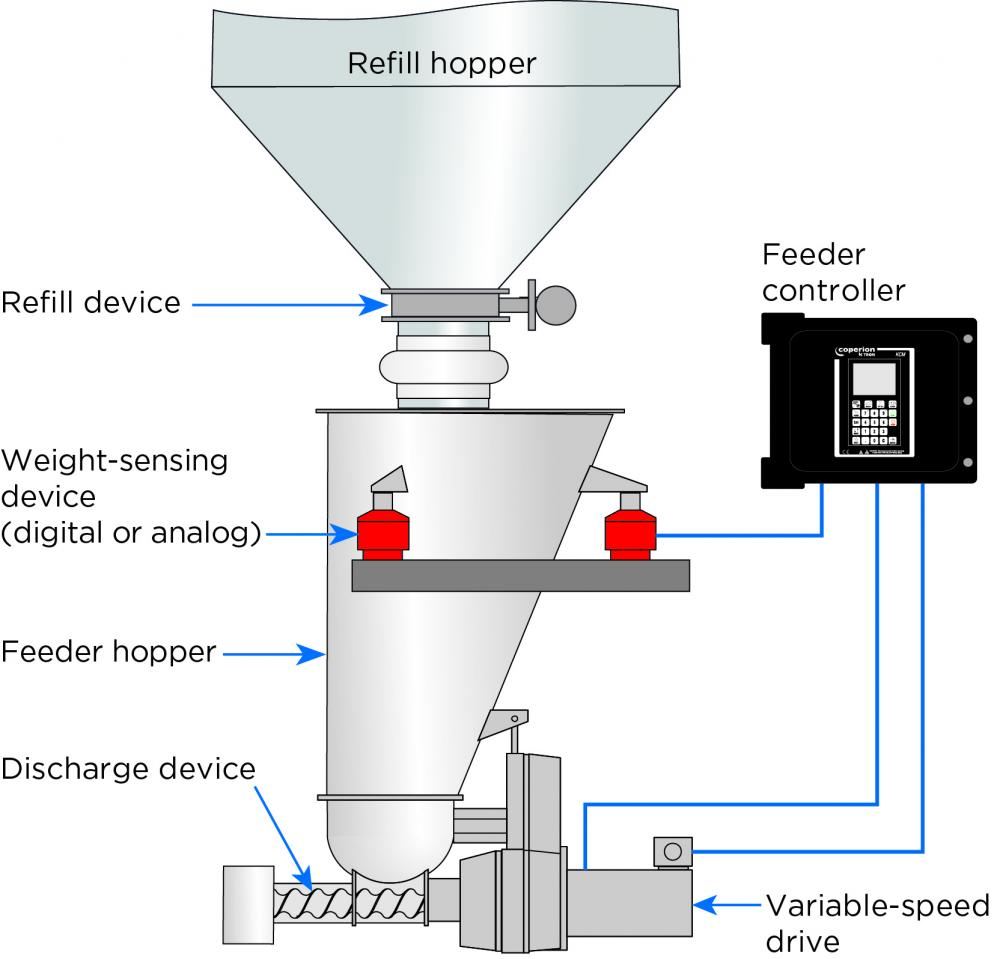

In [15]:
# Include here a descriptive figure of the component (model)
display.Image("figs/hopper.jpg")

**Model Assumptions, Simplifications and future Improvements**

It is assumed that the hopper consists of a cylindrical top part, and a conical bottom part. The height of the cone is assumed to be the same as the diameter of the cylinder. This could be adapted in the model in case a different geometry is desired. 

A constant granular material (regolith) bulk density is considered. Furthermore, it is assumed that lunar regolith has an angle of internal friciton of 40 degrees (Mitchell et al., 1972). It is assumed, that all the material is able to slide out of the hopper and no *dead volumes* exist.

The pressure on the walls is determined with Janssen's Formula (Horabik & Molenda, 2002). The lateral and vertical pressure is both condsidered as a squared sum. The required wall thickness is according to ASME Conical Sections VIII-1 (Farr & Jawad, 2001). In cases where the calculated wall thickness is too thin to be practical, an assumed wall thickness of 2 mm is used. Furthermore, an safety factor of 2 is chosen.

The filling factor considers the increased pressure on the walls while the hopper is being filled compared to static operation. Due to the impacts of the particles, a higher load on the walls can be assumed. A filling factor of 7 is included to ensure safe operation (Tsunakawa & Aoki, 1974).

Only the mass of the hopper walls is considered. Further structural mass, valves, or discharge mechanisms, such as, e.g., an auger conveyor, are not part of this model and should be computed separately.

Future improvements could include:
- Incorporate structural elements
- Add additional geometries, eg. squared. 
- Incorporate a discharge mechanism. 
- Include dead volume and flow behaviour, depending on the geometry and soil properties. 

The rest of the assumptions and possible improvements are explained thoroughly in **3. Model Body**

## 1. Inputs

In [16]:
hopper_capacity     = 200 # kg | Desired regolith storage capacity of the hopper
hopper_inner_radius = 1 # m | Hopper radius (cylinder and cone)

filling_factor = 7 # - | Filling factor. Due to the impacts of the particles, a higher load on the walls can be assumed while filling (Tsunakawa & Aoki, 1974)

## 2. Constants

In [17]:
pi = np.pi # -

gMoon = 1.625 # m/s2 | Gravitational acceleration on the Moon

density_regolith        = 1500 # kg/m3 | Bulk regolith density (Schreiner et al., 2016)
angle_internal_friction = 40*pi/180 # rad | Angle of internal friction of lunar regolith (Mitchell et al., 1972)

density_Al       = 2700 # kg/m3 | Aluminum density (hopper material)
sigma_Al         = 324 # MPa | Yield stress for aluminum, adapted from (Eagle Engineering, 1988)

safety_factor    = 2 # - | Safety factor
minWallThickness = 2e-3 # m | Mininum hopper wall thickness

## 3. Model Body

In [18]:
cone_height = 2*hopper_inner_radius # m | Height of the conical part of the hopper

hopper_volumne  = hopper_capacity/density_regolith # m3 | Volume of the desired total storage capacity
cone_volume     = pi*(hopper_inner_radius**2)*cone_height/3 # m3 | Volume of the cone storage capacity
cylinder_volume = hopper_volumne - cone_volume # m3 | Volume of the cylinder storage capacity
 
if cylinder_volume < 0: # If the desired storage volume alread fits in the conical part, no cylidrical part is considered  
    cylinder_volume = 0 # m3 | Volume of the cylinder storage capacity
        
cylinder_height = cylinder_volume/(pi*hopper_inner_radius**2) # m | height of the cylindrical part     
hopper_height   = cylinder_height + cone_height  # m | height of the hopper         
        
# The wall required thickness is determined with Janssen's Formula (Horabik & Molenda, 2002) and the ASME Conical Section ASME Conical Sections VIII-1 (Farr & Jawad, 2001). 
# Jannsen's Formula determines the pressure in the hopper walls
# ASME lists a correlation between pressure and wall thickness 
JanssensConstant        = 1.1*(1-np.sin(angle_internal_friction)) # - | Janssens constant. Describes the lateral to verical pressure ratio (Horabik & Molenda, 2002)
WallFrictionCoefficient = np.tan(angle_internal_friction) # - | Wall friction coefficent. Estimated via the tangent theorem (Horabik & Molenda, 2002)
Alpha                   = np.arctan(hopper_inner_radius/cone_height) # rad | Alpha is the half opening angle of the cone

# The pressure in z and x direction is determined. Here, the total pressure is additionally considered to be conservative 
Sigma_Z      = (density_regolith*gMoon*(2*hopper_inner_radius)/(4*JanssensConstant*WallFrictionCoefficient))*(1-np.exp(-4*JanssensConstant*WallFrictionCoefficient*hopper_height/(2*hopper_inner_radius))) # Pa | Vertical pressure (Horabik & Molenda, 2002)
Sigma_X     = JanssensConstant*Sigma_Z # Pa | Lateral pressure (Horabik & Molenda, 2002)
Sigma_Total = np.sqrt(Sigma_Z**2+Sigma_X**2) # Pa | Total Pressure is estimated via a squared sum 

# With the pressure, the allowable material stress, and ASME guidelines, the min thickness of a conical part is calculated: The total pressure is multiplied with the Filling Factor.
# The filling factor is included to ensure safety when the hopper is filled, and higher pressures could arise. 
WallThickness = (filling_factor*Sigma_Total*(hopper_inner_radius*safety_factor))/(np.cos(Alpha)*(sigma_Al*10**6-0.6*Sigma_Total)) # m | Wall thickness for a conical section (Farr & Jawad, 2001)

#In cases where the calculated wall thickness is too thin to be practical, an assumed wall thickness is used
if WallThickness < minWallThickness:
     WallThickness = minWallThickness # m | Wall thickness

# The volume of hopper's material is determined via geometrical calculations.         
cone_volume_material     = pi*((hopper_inner_radius + WallThickness)**2 - hopper_inner_radius**2)*cone_height/3 # m3 | Volume of cone material
cylinder_volume_material = pi*cylinder_height*((hopper_inner_radius + WallThickness)**2-hopper_inner_radius**2) # m3 | Volume of cylinder material
hopper_volumne_material  = cone_volume_material + cylinder_volume_material # m3 | Volume of hopper material

# The mass of the hopper is calculated with the density and the total hopper volume 
hopper_mass = hopper_volumne_material*density_Al # kg | Mass of hopper
mass_factor = hopper_mass/hopper_capacity # kg/kg | Mass of hopper per storage capacity 

## 4. Outputs

In [19]:
print("Mass:       ",round(hopper_mass, 2),"kg")
print("Mass factor:",round(mass_factor,4),"kg of hardware mass per kg of stored regolith")

Mass:        22.64 kg
Mass factor: 0.1132 kg of hardware mass per kg of stored regolith


## References

Eagle Engineering Inc, Conceptual Design of a Lunar Oxygen Pilot Plant: LunarBase Systems Study, Tech. Rep. N89-13886, NASA, 1988, URL https://ntrs.nasa.gov/citations/19890004515

J.R. Farr, M.H. Jawad, Guidebook for the design of ASME Section VIII pressure vessels, ASME Press, New York, NY, 2021

J. Horabik, M. Molenda, Properties of Grain for Silo Strength Calculation, in: J. Blahovec, M. Kutílek, (eds) Physical Methods in Agriculture. Springer, Boston, MA, 2002, https://doi.org/10.1007/978-1-4615-0085-8_12

J.K. Mitchell, W.N. Houston, R.F. Scott, N.C. Costes, W.D. Carrier, L.G. Bromwell, Mechanical properties of lunar soil: Density, porosity, cohesion, and angle of internal friction, in: Proceedings of the Third Lunar Science Conference vol.3 3235-3253, 1972, URL: https://adsabs.harvard.edu/full/1972LPSC....3.3235M 

S.S. Schreiner, J.A. Dominguez, L. Sibille, J.A. Hoffman, Thermophysical property models for lunar regolith, Adv. Space Res. 57 (5) (2016) 1209–1222, http://dx.doi.org/10.1016/j.asr.2015.12.035

H. Tsunakawa, R. Aoki, Lateral pressures of granular materials in a model bin, Journal of Chemical Engineering of Japan 7 (2) (1974) 131-134, https://doi.org/10.1252/jcej.7.131